# Aiida

## Define workflow with aiida

In [1]:
from python_workflow_definition.aiida import write_workflow_json
from python_workflow_definition.shared import get_dict, get_list

from aiida import load_profile, orm

load_profile()

workflow_json_filename = "aiida_qe.json"

In [2]:
from aiida_workgraph import task, WorkGraph

In [3]:
from quantum_espresso_workflow import generate_structures
from quantum_espresso_workflow import get_bulk_structure
from quantum_espresso_workflow import calculate_qe as _calculate_qe
from quantum_espresso_workflow import plot_energy_volume_curve

In [4]:
calculate_qe = task(outputs=["energy", "volume", "structure"])(_calculate_qe)

In [5]:
wg = WorkGraph("wg-qe")

### Prepare the inputs

In [6]:
element = orm.Str("Al")
a = orm.Float(4.04)
cubic = orm.Bool(True)
relax_workdir = orm.Str("mini")
pseudopotentials = orm.Dict({"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"})
kpts = orm.List([3, 3, 3])
calc_type_relax = orm.Str("vc-relax")
calc_type_scf = orm.Str("scf")
smearing = orm.Float(0.02)
strain_lst = orm.List([0.9, 0.95, 1.0, 1.05, 1.1])

### Actual tasks to construct the EOS workflow

In [7]:
get_bulk_structure_task = wg.add_task(
    get_bulk_structure,
    name="get_bulk_structure",
    element=element,
    a=a,
    cubic=cubic,
)

In [8]:
relax_prepare_input_dict_task = wg.add_task(
    get_dict,
    name="relax_get_dict",
    structure=get_bulk_structure_task.outputs.result,
    calculation=calc_type_relax,
    kpts=kpts,
    pseudopotentials=pseudopotentials,
    smearing=smearing,
)

relax_task = wg.add_task(
    calculate_qe,
    name="mini",
    input_dict=relax_prepare_input_dict_task.outputs.result,
    working_directory=relax_workdir,
)

In [9]:
generate_structures_task = wg.add_task(
    generate_structures,
    name="generate_structures",
    structure=relax_task.outputs.structure,
    strain_lst=strain_lst,
)

In [10]:
get_volumes_task = wg.add_task(get_list, name="get_volumes")

In [11]:
get_energies_task = wg.add_task(get_list, name="get_energies")

In [12]:
strain_dir_tasks, scf_qe_tasks, scf_get_dict_tasks = [], [], []

for i, strain in enumerate(strain_lst):

    structure_key = f"s_{i}"
    strain_dir = orm.Str(f"strain_{i}")
    generate_structures_task.add_output("workgraph.any", structure_key)

    scf_prepare_input_dict_task = wg.add_task(
        get_dict,
        name=f"get_dict_{i}",
        structure=generate_structures_task.outputs[structure_key],
        calculation=calc_type_scf,
        kpts=kpts,
        pseudopotentials=pseudopotentials,
        smearing=smearing,
    )

    scf_qe_task = wg.add_task(
        calculate_qe,
        name=f"qe_{i}",
        input_dict=scf_prepare_input_dict_task.outputs.result,
        working_directory=strain_dir,
    )

    # collect energy and volume
    get_energies_task.set({f"{i}": scf_qe_task.outputs.energy})
    get_volumes_task.set({f"{i}": scf_qe_task.outputs.volume})

In [13]:
plot_energy_volume_curve_task = wg.add_task(
    plot_energy_volume_curve,
    name="plot_energy_volume_curve",
    volume_lst=get_volumes_task.outputs.result,
    energy_lst=get_energies_task.outputs.result,
)

In [14]:
wg

NodeGraphWidget(settings={'minimap': True}, style={'width': '90%', 'height': '600px'}, value={'name': 'wg-qe',…

In [15]:
_ = write_workflow_json(wg=wg, file_name=workflow_json_filename)


In [16]:
!cat {workflow_json_filename}

{
  "nodes": [
    {
      "id": 0,
      "function": "quantum_espresso_workflow.get_bulk_structure"
    },
    {
      "id": 1,
      "function": "python_workflow_definition.shared.get_dict"
    },
    {
      "id": 2,
      "function": "quantum_espresso_workflow.calculate_qe"
    },
    {
      "id": 3,
      "function": "quantum_espresso_workflow.generate_structures"
    },
    {
      "id": 4,
      "function": "python_workflow_definition.shared.get_list"
    },
    {
      "id": 5,
      "function": "python_workflow_definition.shared.get_list"
    },
    {
      "id": 6,
      "function": "python_workflow_definition.shared.get_dict"
    },
    {
      "id": 7,
      "function": "quantum_espresso_workflow.calculate_qe"
    },
    {
      "id": 8,
      "function": "python_workflow_definition.shared.get_dict"
    },
    {
      "id": 9,
      "function": "quantum_espresso_workflow.calculate_qe"
    },
    {
      "id": 10,
      "function": "python_workflow_definition.shared.get_dic

## Load Workflow with jobflow

In [17]:
from python_workflow_definition.jobflow import load_workflow_json

/srv/conda/envs/notebook/lib/python3.12/site-packages/paramiko/pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "cipher": algorithms.TripleDES,
/srv/conda/envs/notebook/lib/python3.12/site-packages/paramiko/transport.py:253: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  "class": algorithms.TripleDES,


In [18]:
from jobflow.managers.local import run_locally

In [19]:
flow = load_workflow_json(file_name=workflow_json_filename)

In [20]:
flow[0].function_kwargs["a"] = 4.05

2025-04-13 14:45:49,079 INFO Started executing jobs locally
2025-04-13 14:45:49,335 INFO Starting job - get_bulk_structure (52f25cff-b92d-45a2-b1ea-a8b191264397)
2025-04-13 14:45:49,338 INFO Finished job - get_bulk_structure (52f25cff-b92d-45a2-b1ea-a8b191264397)
2025-04-13 14:45:49,339 INFO Starting job - get_dict (dbf35fb4-7dd5-4592-8461-2f7a691816af)
2025-04-13 14:45:49,343 INFO Finished job - get_dict (dbf35fb4-7dd5-4592-8461-2f7a691816af)
2025-04-13 14:45:49,344 INFO Starting job - calculate_qe (23323ecc-8496-442d-8c01-3eec6ec6a14f)


[jupyter-pyiron-dev-pyth-flow-definition-32jomliz:02004] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-04-13 14:46:42,913 INFO Finished job - calculate_qe (23323ecc-8496-442d-8c01-3eec6ec6a14f)
2025-04-13 14:46:42,914 INFO Starting job - generate_structures (2687e78b-fa43-4e66-a6df-3a1b587be5c4)
2025-04-13 14:46:42,921 INFO Finished job - generate_structures (2687e78b-fa43-4e66-a6df-3a1b587be5c4)
2025-04-13 14:46:42,922 INFO Starting job - get_dict (e1e82b39-f266-496e-9b98-d819bcf81562)
2025-04-13 14:46:42,923 INFO Finished job - get_dict (e1e82b39-f266-496e-9b98-d819bcf81562)
2025-04-13 14:46:42,924 INFO Starting job - get_dict (9a9df0c6-24b0-4f22-b8c7-78801c0f06a1)
2025-04-13 14:46:42,925 INFO Finished job - get_dict (9a9df0c6-24b0-4f22-b8c7-78801c0f06a1)
2025-04-13 14:46:42,926 INFO Starting job - get_dict (77ad813a-8e74-40b5-8986-e67f19c6c733)
2025-04-13 14:46:42,927 INFO Finished job - get_dict (77ad813a-8e74-40b5-8986-e67f19c6c733)
2025-04-13 14:46:42,928 INFO Starting job - get_dict (20aeafb3-46f2-4ae8-89f3-8555e1258fe4)
2025-04-13 14:46:42,929 INFO Finished job - get_dict (

[jupyter-pyiron-dev-pyth-flow-definition-32jomliz:02023] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-04-13 14:46:52,802 INFO Finished job - calculate_qe (5b5a7334-f47b-4e63-b4a7-d2b2b8cb67c6)
2025-04-13 14:46:52,803 INFO Starting job - calculate_qe (6707f307-20c9-465e-b56b-c398284a9534)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pyiron-dev-pyth-flow-definition-32jomliz:02033] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-04-13 14:47:05,180 INFO Finished job - calculate_qe (6707f307-20c9-465e-b56b-c398284a9534)
2025-04-13 14:47:05,181 INFO Starting job - calculate_qe (f7ede7fe-5d50-48f3-8c92-47ebac40e251)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pyiron-dev-pyth-flow-definition-32jomliz:02043] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-04-13 14:47:18,483 INFO Finished job - calculate_qe (f7ede7fe-5d50-48f3-8c92-47ebac40e251)
2025-04-13 14:47:18,484 INFO Starting job - calculate_qe (17f97b26-39a6-40ee-ad1f-30e2893e112c)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pyiron-dev-pyth-flow-definition-32jomliz:02054] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


2025-04-13 14:47:32,819 INFO Finished job - calculate_qe (17f97b26-39a6-40ee-ad1f-30e2893e112c)
2025-04-13 14:47:32,820 INFO Starting job - calculate_qe (66f55d15-95a1-4d15-9e44-848f97a99604)


Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG
[jupyter-pyiron-dev-pyth-flow-definition-32jomliz:02065] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


2025-04-13 14:47:49,325 INFO Finished job - calculate_qe (66f55d15-95a1-4d15-9e44-848f97a99604)
2025-04-13 14:47:49,326 INFO Starting job - get_list (7d1db6bf-0c07-4708-8af4-316329264c03)
2025-04-13 14:47:49,330 INFO Finished job - get_list (7d1db6bf-0c07-4708-8af4-316329264c03)
2025-04-13 14:47:49,330 INFO Starting job - get_list (35327497-13f7-4044-a43c-01ac93b742ed)
2025-04-13 14:47:49,333 INFO Finished job - get_list (35327497-13f7-4044-a43c-01ac93b742ed)
2025-04-13 14:47:49,334 INFO Starting job - plot_energy_volume_curve (ba8fd55e-8d10-42b7-b44b-f0aefaf09168)
2025-04-13 14:47:49,419 INFO Finished job - plot_energy_volume_curve (ba8fd55e-8d10-42b7-b44b-f0aefaf09168)
2025-04-13 14:47:49,420 INFO Finished executing jobs locally


{'52f25cff-b92d-45a2-b1ea-a8b191264397': {1: Response(output='{"immutable_id": null, "last_modified": null, "elements": ["Al"], "nelements": 1, "elements_ratios": [1.0], "chemical_formula_descriptive": "Al4", "chemical_formula_reduced": "Al", "chemical_formula_hill": null, "chemical_formula_anonymous": "A", "dimension_types": [1, 1, 1], "nperiodic_dimensions": 3, "lattice_vectors": [[4.05, 0.0, 0.0], [0.0, 4.05, 0.0], [0.0, 0.0, 4.05]], "space_group_symmetry_operations_xyz": null, "space_group_symbol_hall": null, "space_group_symbol_hermann_mauguin": null, "space_group_symbol_hermann_mauguin_extended": null, "space_group_it_number": null, "cartesian_site_positions": [[0.0, 0.0, 0.0], [0.0, 2.025, 2.025], [2.025, 0.0, 2.025], [2.025, 2.025, 0.0]], "nsites": 4, "species": [{"name": "Al", "chemical_symbols": ["Al"], "concentration": [1.0], "mass": null, "original_name": null, "attached": null, "nattached": null}], "species_at_sites": ["Al", "Al", "Al", "Al"], "assemblies": null, "structur

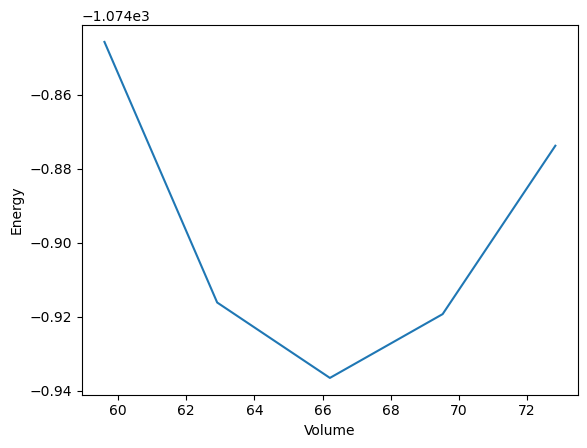

In [21]:
result = run_locally(flow)
result

## Load Workflow with pyiron_base

In [22]:
from pyiron_base import Project

In [23]:
from python_workflow_definition.pyiron_base import load_workflow_json

In [24]:
pr = Project("test")
pr.remove_jobs(recursive=True, silently=True)

0it [00:00, ?it/s]

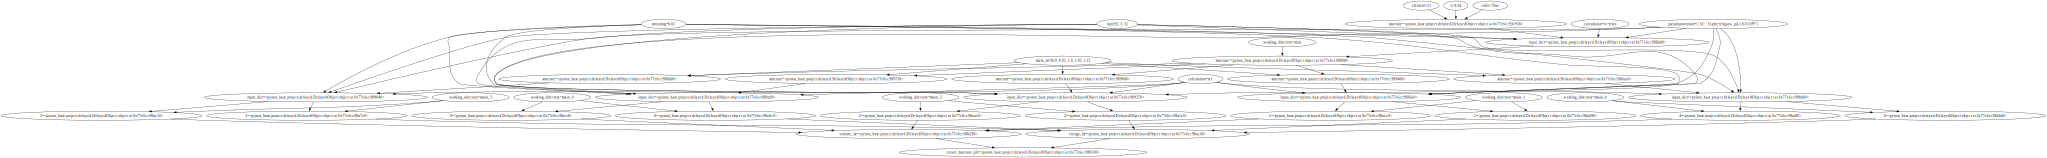

In [25]:
delayed_object_lst = load_workflow_json(project=pr, file_name=workflow_json_filename)
delayed_object_lst[-1].draw()

In [26]:
delayed_object_lst[0]._input['kwargs']['a'] = 4.05

The job get_bulk_structure_f1e730ed97e30e5439e855d2ac41396f was saved and received the ID: 1
The job get_dict_20400c1655d51731f9f5ffb50c2b401f was saved and received the ID: 2
The job calculate_qe_22b5d0934d89d8f08761e744e4612c30 was saved and received the ID: 3


[jupyter-pyiron-dev-pyth-flow-definition-32jomliz:02098] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job generate_structures_620afd79eb4ef3462e4262af0e8f56d5 was saved and received the ID: 4
The job get_dict_017f13c172d209895b8f8b703ea9d410 was saved and received the ID: 5
The job calculate_qe_48a156b6666b76c0a6642aa0941d54eb was saved and received the ID: 6


[jupyter-pyiron-dev-pyth-flow-definition-32jomliz:02120] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_42798e9241f7b1d9849513c0b7c57f90 was saved and received the ID: 7
The job calculate_qe_6d537f5ff9b80f1d75b0b746929471cb was saved and received the ID: 8


[jupyter-pyiron-dev-pyth-flow-definition-32jomliz:02130] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_e2621f0a99743f7b3a5bdeaea593910d was saved and received the ID: 9
The job calculate_qe_a0ae12ca82833ddd18a73ebeef089146 was saved and received the ID: 10


[jupyter-pyiron-dev-pyth-flow-definition-32jomliz:02140] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_102e8e63edadb2e27ade53b250d11b31 was saved and received the ID: 11
The job calculate_qe_c5700307d7d7b6f9ade984913ff35579 was saved and received the ID: 12


[jupyter-pyiron-dev-pyth-flow-definition-32jomliz:02150] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_dict_9e12b1c04e74bea6ae25bcd7ee825263 was saved and received the ID: 13
The job calculate_qe_57075d35484020a2ead979fb91d71798 was saved and received the ID: 14


[jupyter-pyiron-dev-pyth-flow-definition-32jomliz:02160] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG


The job get_list_5f641376fc06518cf3264bd6148cd6ed was saved and received the ID: 15
The job get_list_e468c0b71116b1fba2e875bcb4662daf was saved and received the ID: 16
The job plot_energy_volume_curve_ed64803dab8555343f266e91c3aac962 was saved and received the ID: 17


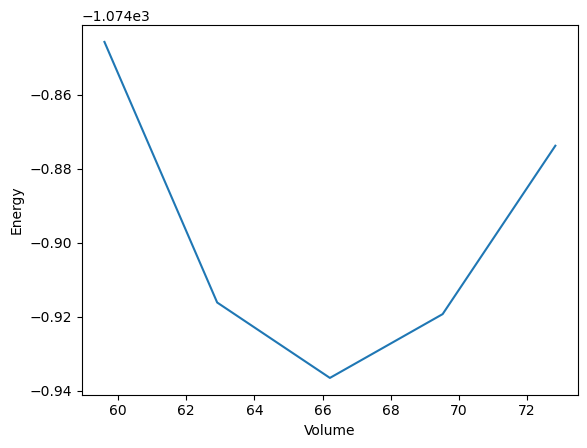

In [27]:
delayed_object_lst[-1].pull()